# Settings

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Google Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 必要なライブラリのインストール

In [ ]:
import warnings
warnings.simplefilter('ignore')

import os
import gc
gc.enable()
import sys
import glob
import math
import time
import random

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import mean_squared_error

from datetime import datetime
from tqdm.auto import tqdm as tqdmp
from tqdm.autonotebook import tqdm as tqdm
tqdmp.pandas()

# import lightly

# TTA
# import ttach as tta

# Config

In [ ]:
class CFG:
  def __init__(self):

      self.wandb = False
      self.debug = False
      self.early_stop_flg = True
      self.early_stop_round = 4
      self.exp_name = '065_exp'
      self.seed = 55
      self.n_fold = 4
      self.num_workers = 1
      self.model_name = 'vit_large_patch16_384'
      self.mode = 'Classification'
      self.padding = False
      self.multitask = False
      self.SSL = False
      self.size = 384
      self.fold = []

      self.epochs = 10
      self.batch_size = 2
      self.lr = 1e-5
      self.weight_decay = 1e-6
      self.scheduler = 'scheduler:CosineAneelingLR'
      self.eta_min = 0
      self.T_max = self.epochs
      self.MIXUP = False
      self.TTA = False
      self.alpha = 1.0
      self.n_tta = 10
      self.accumulation_steps = 8
      self.N_MSD = 10
      self.MIXOUT = 0.5

CONFIG = CFG()

In [ ]:
def seed_everything(seed:int==42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CONFIG.seed)

# Data Load

In [ ]:
INPUT_DIR = "/content/drive/MyDrive/nihonga/data/"

EXP_NAME = f'{CONFIG.exp_name}'
OUTPUT_DIR = f'/content/drive/MyDrive/nihonga/interim/{EXP_NAME}/'
MODEL_DIR = f'/content/drive/MyDrive/nihonga/model/{EXP_NAME}/'
OOF_DIR = f'/content/drive/MyDrive/nihonga/oof/{EXP_NAME}/'
SUB_DIR = f'/content/drive/MyDrive/nihonga/sub/{EXP_NAME}/'

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(OOF_DIR, exist_ok=True)
os.makedirs(SUB_DIR, exist_ok=True)

print(f'INPUT_DIR: {INPUT_DIR}')
print(f'OUTPUT_DIR: {OUTPUT_DIR}')
print(f'MODEL_DIR: {MODEL_DIR}')
print(f'OOF_DIR: {OOF_DIR}')
print(f'SUB_DIR: {SUB_DIR}')

INPUT_DIR: /content/drive/MyDrive/nihonga/data/
OUTPUT_DIR: /content/drive/MyDrive/nihonga/interim/065_exp/
MODEL_DIR: /content/drive/MyDrive/nihonga/model/065_exp/
OOF_DIR: /content/drive/MyDrive/nihonga/oof/065_exp/
SUB_DIR: /content/drive/MyDrive/nihonga/sub/065_exp/


In [ ]:
train_img = np.load(os.path.join(INPUT_DIR,
                                'train_data.npz'))
test_img = np.load(os.path.join(INPUT_DIR,
                                'test_data.npz'))
sub_df = pd.read_csv(os.path.join(INPUT_DIR,
                                'submission.csv'))

In [ ]:
train_df = pd.DataFrame(range(6446),columns=['id'])
train_df['label'] = train_img['arr_1']
test_df = pd.DataFrame(range(test_img['arr_0'].shape[0]),columns=['id'])
if CONFIG.debug:
    train_df = train_df.head(100)
    test_df = test_df.head(50)

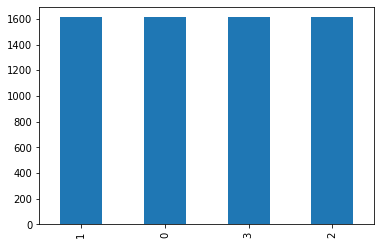

In [ ]:
train_df['fold'] = -1
strat_kfold = StratifiedKFold(n_splits=CONFIG.n_fold, random_state=CONFIG.seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['label'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

train_df.fold.value_counts().plot.bar()

In [ ]:
train_df[train_df['fold']==1]['label'].value_counts()

0    754
1    550
2    155
3    153
Name: label, dtype: int64

## 各種実験のcsvファイルを読み込む

In [ ]:
from sklearn.metrics import f1_score

def get_score(y_true, y_pred):
    score = f1_score(y_true, y_pred,average='macro')
    return score

In [ ]:
oof_23 = pd.read_csv('/content/drive/MyDrive/nihonga/oof/023_exp/023_exp_oof_preds_0.86753.csv')
sub_23 = pd.read_csv('/content/drive/MyDrive/nihonga/sub/023_exp/023_exp_sub_preds_0.86753.csv')
oof_30 = pd.read_csv('/content/drive/MyDrive/nihonga/oof/030_exp/030_exp_oof_preds_0.87357.csv')
sub_30 = pd.read_csv('/content/drive/MyDrive/nihonga/sub/030_exp/030_exp_sub_preds_0.87357.csv')
oof_49 = pd.read_csv('/content/drive/MyDrive/nihonga/oof/049_exp/049_exp_oof_preds_0.86111.csv')
sub_49 = pd.read_csv('/content/drive/MyDrive/nihonga/sub/049_exp/049_exp_sub_preds_0.86111.csv')
oof_57 = pd.read_csv('/content/drive/MyDrive/nihonga/oof/057_exp/057_exp_oof_preds_0.87841.csv')
sub_57 = pd.read_csv('/content/drive/MyDrive/nihonga/sub/057_exp/057_exp_sub_preds_0.87841.csv')
oof_62 = pd.read_csv('/content/drive/MyDrive/nihonga/oof/062_exp/062_exp_oof_preds_0.86057.csv')
sub_62 = pd.read_csv('/content/drive/MyDrive/nihonga/sub/062_exp/062_exp_sub_preds_0.86057.csv')

In [ ]:
p_list = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

col_list = ['label_0','label_1','label_2','label_3']
gt = oof_23['label'].values
best_score = 0
for p in p_list:
    for q in p_list:
      if np.round(p + q,1) > 1:
        continue
      for r in p_list:
        if np.round(p + q + r,1) > 1:
          continue
        for s in p_list:
          if np.round(p + q + r + s,1) > 1:
            continue
          for t in p_list:
            oof_v = oof_49[col_list].values * p + oof_57[col_list].values * q + oof_30[col_list].values * r + oof_62[col_list].values * s + oof_23[col_list].values * t + oof_52[col_list].values * (1-p-q-r-s-t)
            oof_pred = np.argmax(oof_v, axis=1)
            score = get_score(gt,oof_pred)
            if best_score < score:
              best_score = score
              print(f'oof_49:{p} | oof_57:{q} | oof_30:{r} | oof_62:{s} | oof_23:{t} | oof_52:{1-p-q-r-s-t:.1f} | score: {score:.5f}')

oof_49:0 | oof_57:0 | oof_30:0 | oof_62:0 | oof_23:0 | oof_52:1.0 | score: 0.88048
oof_49:0 | oof_57:0 | oof_30:0 | oof_62:0 | oof_23:0.4 | oof_52:0.6 | score: 0.88082
oof_49:0 | oof_57:0 | oof_30:0 | oof_62:0.1 | oof_23:0.3 | oof_52:0.6 | score: 0.88245
oof_49:0 | oof_57:0 | oof_30:0 | oof_62:0.1 | oof_23:0.4 | oof_52:0.5 | score: 0.88602
oof_49:0 | oof_57:0 | oof_30:0 | oof_62:0.2 | oof_23:0.3 | oof_52:0.5 | score: 0.88607
oof_49:0 | oof_57:0 | oof_30:0 | oof_62:0.3 | oof_23:0.2 | oof_52:0.5 | score: 0.88728
oof_49:0 | oof_57:0 | oof_30:0 | oof_62:0.3 | oof_23:0.3 | oof_52:0.4 | score: 0.89041
oof_49:0 | oof_57:0 | oof_30:0 | oof_62:0.5 | oof_23:0.2 | oof_52:0.3 | score: 0.89091
oof_49:0 | oof_57:0 | oof_30:0 | oof_62:0.5 | oof_23:0.3 | oof_52:0.2 | score: 0.89270
oof_49:0 | oof_57:0 | oof_30:0.2 | oof_62:0.4 | oof_23:0.2 | oof_52:0.2 | score: 0.89322
oof_49:0 | oof_57:0 | oof_30:0.3 | oof_62:0.5 | oof_23:0 | oof_52:0.2 | score: 0.89343
oof_49:0 | oof_57:0 | oof_30:0.3 | oof_62:0.5 |

In [ ]:
sub = sub_49[col_list].values * 0.2 + sub_30[col_list].values * 0.1 + sub_57[col_list].values * 0.2 + sub_23[col_list].values * 0.1 + sub_62[col_list].values * 0.4
sub_pred = np.argmax(sub, axis=1)
sub_pred

array([1, 0, 0, ..., 2, 1, 1])

In [ ]:
pseudo_df = pd.DataFrame(sub)
pseudo_df.columns = ['label_0','label_1','label_2','label_3']
pseudo_df['label'] = np.argmax(sub, axis=1)
pseudo_df = pd.concat([test_df,pseudo_df], axis=1)
pseudo_df.to_csv(os.path.join(OUTPUT_DIR, f'{CONFIG.exp_name}_pseudo_{best_score:.5f}.csv'),index=False)
pseudo_df.head()

,id,label_0,label_1,label_2,label_3,label
0,0,0.002095,0.990006,0.000793,0.007106,1
1,1,0.904510,0.091105,0.001927,0.002457,0
2,2,0.992745,0.002890,0.003510,0.000854,0
3,3,0.047024,0.002705,0.891481,0.058790,2
4,4,0.019404,0.752677,0.226373,0.001547,1


In [ ]:
sub_df['y'] = np.argmax(sub, axis=1)
sub_df.to_csv(os.path.join(SUB_DIR, f'{CONFIG.exp_name}_sub_ensenble_49_30_57_23_62_{best_score:.5f}.csv'),index=False)
sub_df

,id,y
0,1,1
1,2,0
2,3,0
3,4,2
4,5,1
...,...,...
1995,1996,1
1996,1997,1
1997,1998,2
1998,1999,1
